### Abstract

[Find the source code here](https://github.com/carlymcadam/carlymcadam.github.io/blob/main/posts/overfitting-overparameterization-double-descent/logistic.py)

In this blog post, we'll explore overfitting and double descent. We will use overparameterization to exemplify what it looks like when a model is overfit, and we'll see how models can learn patterns that are too specific to the training set and don't generalize well. We will also look at an example of detecting corruption in images that will show us that interpolating the data is not always bad and can sometimes lead to a more accurate model, despite that we may worry about overfitting. 

### Part 0

We know that the closed-form solution for ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍least-squares ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍linear ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍regression is:

$\hat{w} = (X^tX)^{-1}X^ty$ 

only if the number of data observations $n$ is larger than the number of features $p$. When $p$ is larger than $n$, the matrix $X^tX$ becomes no longer invertible. When $p > n$, the columns of $X$ are linearly dependent -- there are more variables than there are equations to describe their relationships, which makes the columns in the matrix $X$ linearly dependent. This causes $X^tX$ to not be invertible, so the equation for $\hat{w}$ no longer works. 

In [2]:
#| include: false
import torch
from logistic import MyLinearRegression, OverParameterizedLinearRegressionOptimizer, RandomFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_sample_images
from scipy.ndimage import zoom

### Testing Model on Simple Data

We're going to be using a linear model that inherits from the linear model that we wrote for the previous blog post. See the source code (linked above) for the details. We'll first try to fit the model to some simple 1-d data. 

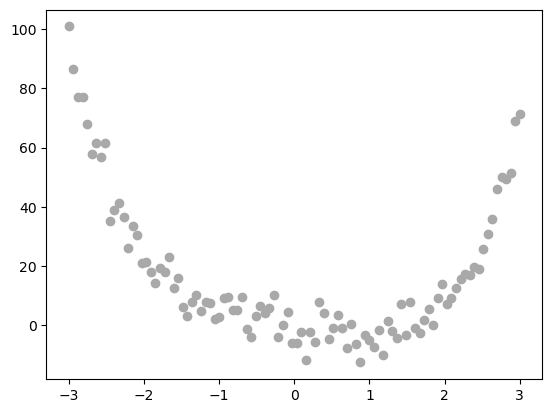

In [3]:
# Create the nonlinear dataset
X = torch.tensor(np.linspace(-3, 3, 100).reshape(-1, 1), dtype = torch.float64)
y = X**4 - 4*X + torch.normal(0, 5, size=X.shape)

# Plot to get an idea of what we're trying to fit
plt.scatter(X, y, color='darkgrey', label='Data')

In order to fit a model to this nonlinear dataset, we first need to use the RandomFeatures class to generate a set of features. This class creates a
random sigmoidal feature map that must be "fit" before use. This process fits progressively ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍more ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍complex linear regression models that have more random features to the same dataset of a small size. Eventually, the complex models will be able to perfectly model the training set but not generalize to the test data. The large number of parameters allows the model to learn‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍ intricate patterns in the test data, but these patterns don't necessarily generalize to the test data. We'll do this by feeding the random feature set into our custom linear regression model. 

In [4]:
# Generate random nonlinear features
phi = RandomFeatures(n_features=100)
phi.fit(X)  
X_phi = phi.transform(X)  

Now, we'll feed this feature set into our model:

In [5]:
# Train the model
model = MyLinearRegression()
optimizer = OverParameterizedLinearRegressionOptimizer(model)
optimizer.fit(X_phi, y)  

# Predict
y_pred = model.predict(X_phi)

And plot the data versus the predictions from our model:

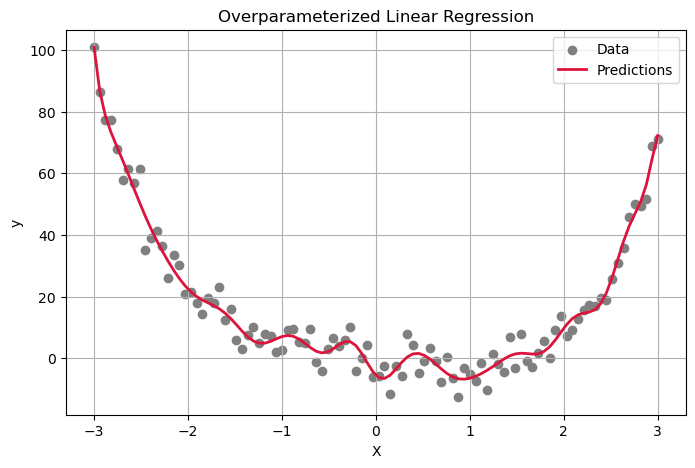

In [6]:
# Plot predictions vs. true data
plt.figure(figsize=(8, 5))
plt.scatter(X.numpy(), y.numpy(), color='gray', label='Data')
plt.plot(X.numpy(), y_pred, color='crimson', linewidth=2, label='Predictions')
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.title("Overparameterized Linear Regression")
plt.grid(True)
plt.show()

We can see that the overparameterized model does a good job of modeling the patterns in the training set, even picking up small nuances that may not necessarily generalize to a larger test set. A more generalizable version of this model might have a red prediction line that matches the general shape of the training data well but doesn't include the smaller bumps up and down that can be seen in the training data. 

### Double Descent In Image Corruption Detection

Now, we're going to apply this method to a more complex dataset to highlight the difference in performance between the test and training sets with an overparameterized model. We will use an image of a flower and try to predict how many patches of solid pixels are present in a corrupted version of the image. 

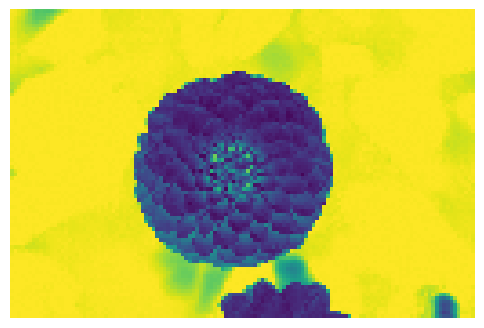

In [7]:
# Load the dataset of images and plot to see what they look like
dataset = load_sample_images()     
X = dataset.images[1]
X = zoom(X,.2) #decimate resolution
X = X.sum(axis = 2)
X = X.max() - X 
X = X / X.max()
flower = torch.tensor(X, dtype = torch.float64)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(flower)
off = ax.axis("off")

In [8]:
#| code-fold: true
#| code-summary: "Function to make corrupted image"

# Function to corrupt the image by adding random blocks of solid colored pixels
def corrupted_image(im, mean_patches = 5): 
    n_pixels = im.size()
    num_pixels_to_corrupt = torch.round(mean_patches*torch.rand(1))
    num_added = 0

    X = im.clone()

    for _ in torch.arange(num_pixels_to_corrupt.item()): 
        
        try: 
            x = torch.randint(0, n_pixels[0], (2,))

            x = torch.randint(0, n_pixels[0], (1,))
            y = torch.randint(0, n_pixels[1], (1,))

            s = torch.randint(5, 10, (1,))
            
            patch = torch.zeros((s.item(), s.item()), dtype = torch.float64) + 0.5

            # place patch in base image X
            X[x:x+s.item(), y:y+s.item()] = patch
            num_added += 1

            
        except: 
            pass

    return X, num_added

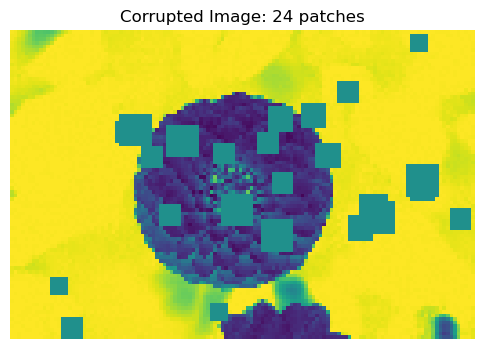

In [9]:
# Take a look at the corrupted image
X, y = corrupted_image(flower, mean_patches = 50)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(X.numpy(), vmin = 0, vmax = 1)
ax.set(title = f"Corrupted Image: {y} patches")
off = plt.gca().axis("off")

Here we can see that the image has blocks of solid colored pixels that make the image corrupt. We want to use our model to predict how many of these corrupted blocks are going to be in an image from just the image itself. We will start by creating a dataset of corrupted images. 

In [10]:
# Prepare data
n_samples = 200
image_dim = flower.shape
X = torch.zeros((n_samples, image_dim[0], image_dim[1]), dtype=torch.float64)
y = torch.zeros(n_samples, dtype=torch.float64)
for i in range(n_samples):
    X[i], y[i] = corrupted_image(flower, mean_patches=100)

X = X.reshape(n_samples, -1) # Reshape the image 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42) # Split into train and test sets

Now, we want to to assess the performance of the overparametrized model. We will use a loop to vary the number of features that we use in the RandomFeatures class to find the number of features that yields the smallest mean squared error. 

In [11]:
# Parameters
max_features = 200
training_errors = [] # Lists to keep track of errors
testing_errors = []
feature_counts = list(range(1, max_features + 1)) # Test 1-200 features

# Loop through different numbers of features and get error

for n_features in feature_counts:

    # Generate ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍features ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍from ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍a ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍data ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍matrix
    phi = RandomFeatures(n_features=n_features, activation=lambda x: x**2) # Make the random feature map with square activation function
    phi.fit(X_train) 
    X_train_phi = phi.transform(X_train)
    X_test_phi = phi.transform(X_test)
    
    model = MyLinearRegression() # Initialize the model
    optimizer = OverParameterizedLinearRegressionOptimizer(model)
    optimizer.fit(X_train_phi, y_train) # Fit to the training set with the random features from above

    y_train_pred = model.predict(X_train_phi) # Make predictions for train set
    y_test_pred = model.predict(X_test_phi) # Make predictions for test set

    training_mse = mean_squared_error(y_train.numpy(), y_train_pred.detach().numpy()) # Get MSE for train set
    testing_mse = mean_squared_error(y_test.numpy(), y_test_pred.detach().numpy()) # Get MSE for test set

    # Add errors to list for plotting 
    training_errors.append(training_mse)
    testing_errors.append(testing_mse)

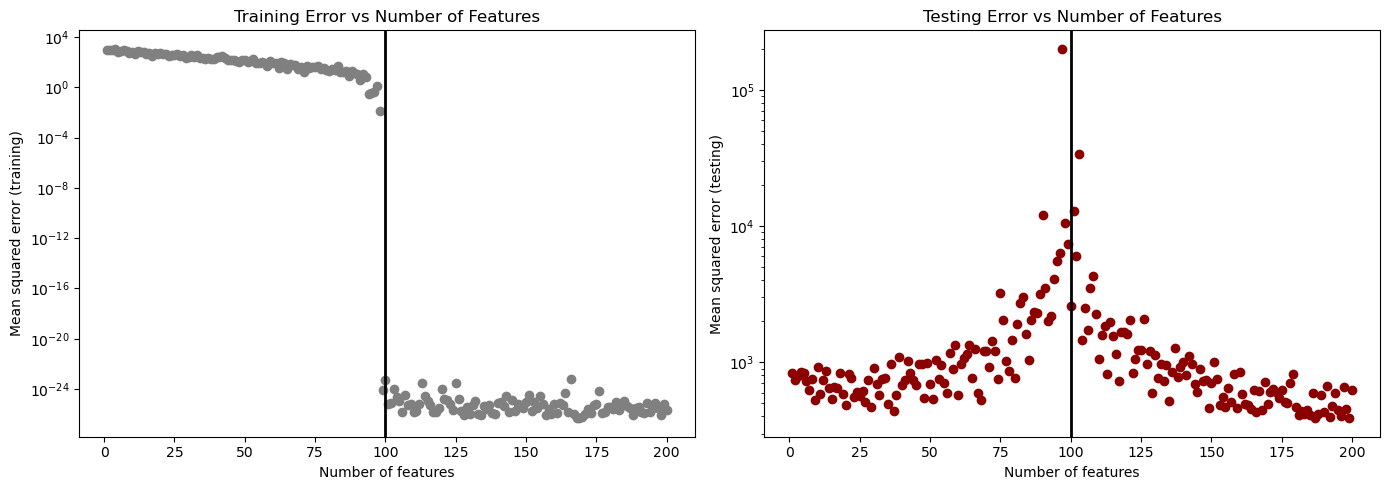

Best testing error achieved with 187 features.


In [12]:
#| code-fold: true
#| code-summary: "Plotting features and error"

# Interpolation threshold (where n_features = n_samples)
interp_threshold = X_train.shape[0]

# Make 2 plots
plt.figure(figsize=(14, 5))

# Training error
plt.subplot(1, 2, 1)
plt.plot(feature_counts, training_errors, 'o', color='gray')
plt.axvline(interp_threshold, color='black', linewidth=2)
plt.yscale("log")
plt.xlabel("Number of features")
plt.ylabel("Mean squared error (training)")
plt.title("Training Error vs Number of Features")

# Testing error
plt.subplot(1, 2, 2)
plt.plot(feature_counts, testing_errors, 'o', color='darkred')
plt.axvline(interp_threshold, color='black', linewidth=2)
plt.yscale("log")
plt.xlabel("Number of features")
plt.ylabel("Mean squared error (testing)")
plt.title("Testing Error vs Number of Features")

plt.tight_layout()
plt.show()

# Print best result
best_idx = np.argmin(testing_errors)
best_n_features = feature_counts[best_idx]
print(f"Best testing error achieved with {best_n_features} features.")


 Taking a look at these plots, we can see in the left plot that as we increase the number of features with the test set, the mean squared error immediately drops as we pass the interpolation threshold. This makes sense-- as we discussed above, overparameterizing the model on the training set allows the model to predict the training set very well, as it learns complex patterns about the data. On the test set, we can see that when we used 179 features, we had the lowest mean squared error. This is an example of double descent, as we approach the interpolation threshold, the testing error increases, but then begins to decrease as we pass the interpolation threshold. This suggests that ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍interpolating the data is not always bad, as we generalized above. Instead, sometimes this process can lead to reasonable-looking models, as we can see from the image corruption dataset. We were actually able to decrease the testing error to its lowest after passing the interpolation threshold. 

### Discussion

We looked at a few different examples here of how overfitting can come into play in machine learning. We saw that when we used a random feature map to train our linear regression model, our model was able to fit the training data very well and learn complex trends in the data. But, we also discussed how this is not necessarily the best way to train a model, because it doesn't always generalize well to the test set. But, our impage corruption detection example provided a different result -- that our test error actually ended up being lowest when we had passed the interpolation threshold, an example of double-descent. Ultimately, it's essential to understand the potential causes and ramifications of overfitting, as it is one of the major concerns of machine learning models. But, we also gained another perspective from this blog post that is particularly applicable in deep learning, that sometimes linear interpolation can lead to success in models.   